# **Introduction:**
We are going to build a model that predict, whether the purchase is happened before the customer leaves the website. We are first clustering the customers and then using SVM Modelling for predicting the purchase.*italicized text*


Steps we are following


1. Loading data
2. Pre-Clustering EDA
3. Pre-Clustering Data Preparation
4. Cluster Modelling
5. Post-Clustering EDA
6. Clustering Output Vs Actual labels
7. SVM Modelling
8. Select Models
9. Clustering + SVM Output Vs Actual labels
10. Conclusion



**Introduction to the Dataset:**
The dataset comprises various web page metrics recorded for an e-commerce site, such as types and duration of pages visited, along with Google Analytics metrics like Bounce Rate, Exit Rate, and Page Value. Additionally, it contains categorical data about the visit such as the Operating System, Browser, Region, Traffic Type, Visitor Type, and temporal information like whether the visit occurred on a Weekend and the Month of the visit. This rich dataset is instrumental for understanding visitor behavior and predicting e-commerce transactions.

1. **Administrative:** Integer. Number of administrative pages visited by the user in the session.
2. **Administrative Duration:** Numeric. Total time spent on administrative pages.
3. **Informational:** Integer. Number of informational pages visited during the session.
4. **Informational Duration:** Numeric. Total time spent on informational pages.
5. **Product Related:** Integer. Number of product-related pages visited.
6. **Product Related Duration:** Numeric. Total time spent on product-related pages.
7. **Bounce Rate:** Numeric. The percentage of visitors who navigate away from the site after viewing only one page.
8. **Exit Rate:** Numeric. The percentage of all views that were the last in the session, for a specific page.
9. **Page Value:** Numeric. The average value of a page that a user visited before completing an e-commerce transaction.
10. **Special Day:** Numeric. Indicates the closeness of the site visit time to a specific special day.
11. **Operating System:** Categorical. The type of operating system used by the visitor.
12. **Browser:** Categorical. The type of browser used by the visitor.
13. Region: Categorical. The region from which the session has been started by the visitor.
14. **Traffic Type:** Categorical. Type of traffic that directed the visitor to the website.
15. **Visitor Type:** Categorical. Indicates whether the visitor is new or returning.
16. **Weekend:** Boolean. Indicates whether the visit took place on a weekend.
Month: Categorical. The month of the year when the visit occurred.




In [1]:
### Import packages

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os
from datetime import datetime

from scipy import stats




# **Data Loading**

In [2]:
github_url1 = 'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/Project%202%20Clustering%20%2B%20SVM%20to%20Predict%20Online%20Purchases/Project2_Data.csv'
github_url2 = 'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/Project%202%20Clustering%20%2B%20SVM%20to%20Predict%20Online%20Purchases/Project2_Data_Labels.csv'

df = pd.read_csv(github_url1)
Revlabels_df = pd.read_csv(github_url2)

In [3]:
df.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.0,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.5,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False


In [4]:
Revlabels_df.head(2)

,Revenue
0,True
1,False


In [5]:
Revlabels_df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

This shows the data is Imbalanced.

# **Data Cleaning**

In [6]:
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [8]:
print("No of duplicate rows: ",df.duplicated().sum())

df = df.drop_duplicates(keep='first').reset_index(drop=True)

print("No of duplicate rows after dropping duplicates: ",df.duplicated().sum())

df.head(2)

No of duplicate rows:  125
No of duplicate rows after dropping duplicates:  0


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.0,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.5,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False


There are no missing values and all datatypes are correct, but there are some duplicate values which we dropped, lets start with EDA.

# **Pre-Clustering EDA**

In [9]:
def Hist_BoxPlotFunction(df, pdf_filename):

    # Path for saving the PDF in the current working directory
    pdf_path = os.path.join(os.getcwd(), pdf_filename)

    quantitative_columns = df.select_dtypes(include=['float64', 'int64','int32']).columns

    with PdfPages(pdf_path) as pdf:
        for col in quantitative_columns:
            fig, axs = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram
            sns.histplot(df[col], ax=axs[0], kde=True)
            axs[0].set_title(f'Histogram of {col}')

            # Box Plot
            sns.boxplot(x=df[col], ax=axs[1])
            axs[1].set_title(f'Box Plot of {col}')

            plt.tight_layout()
            pdf.savefig(fig)  # Save the figure into the PDF
            plt.show()  # Display the plot
            plt.close(fig)  # Close to free up memory

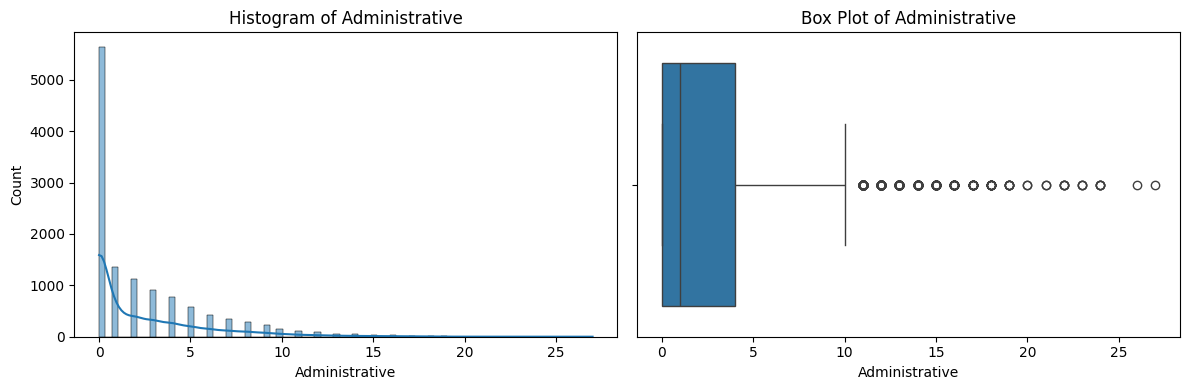

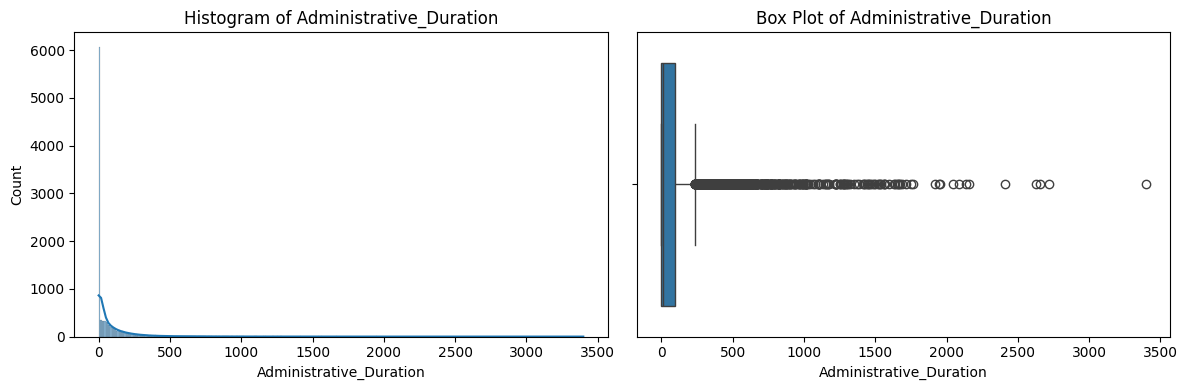

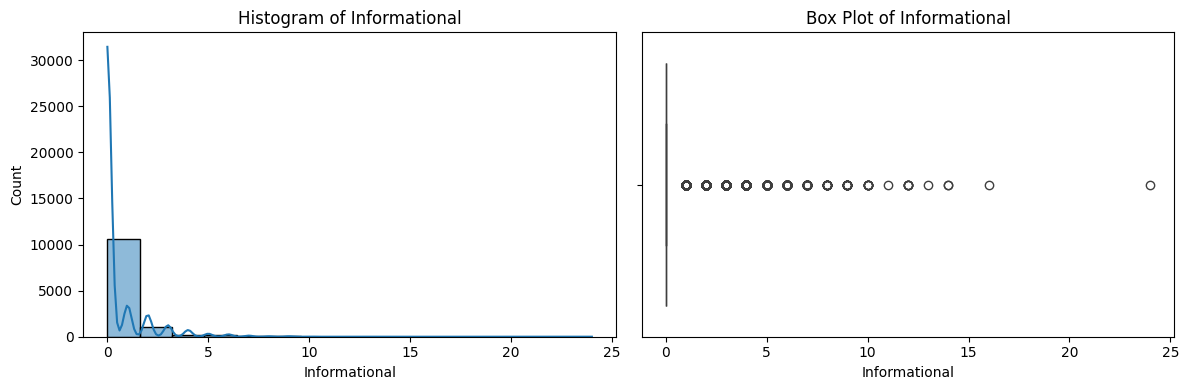

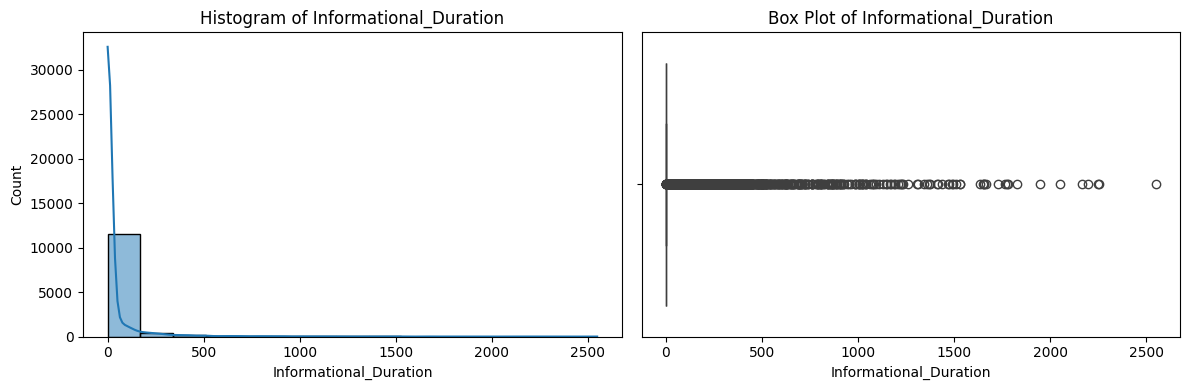

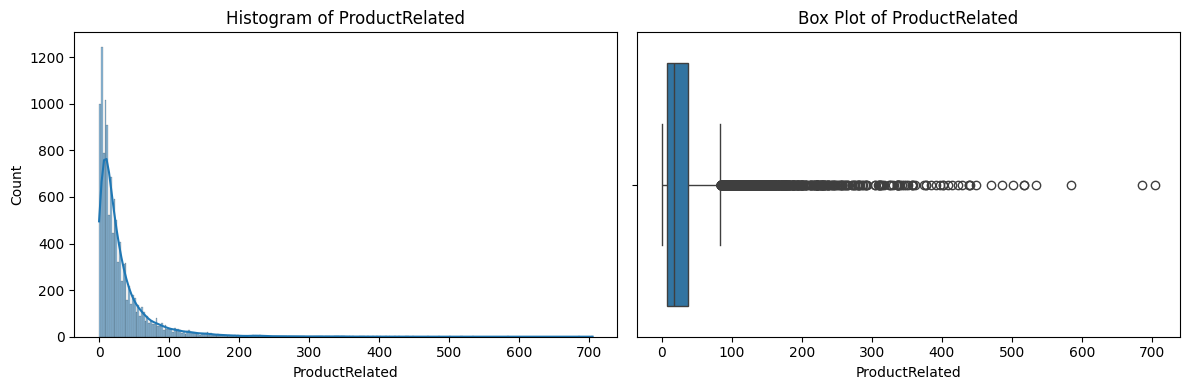

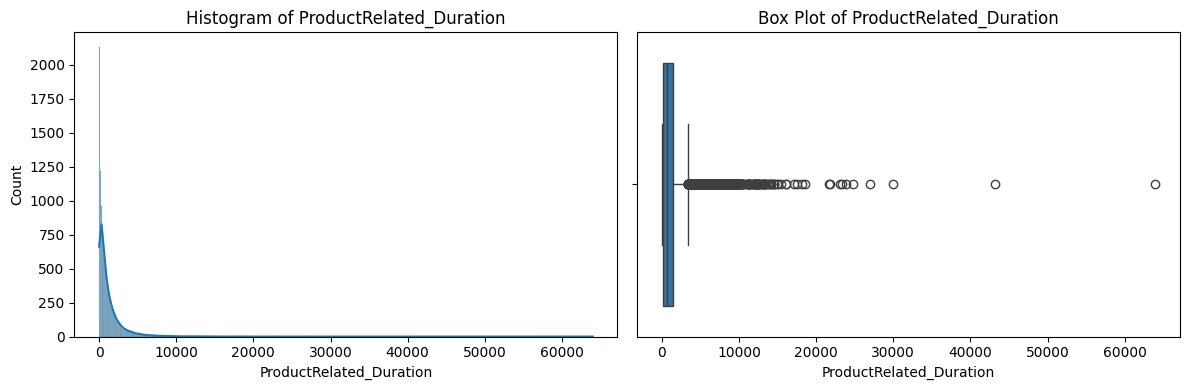

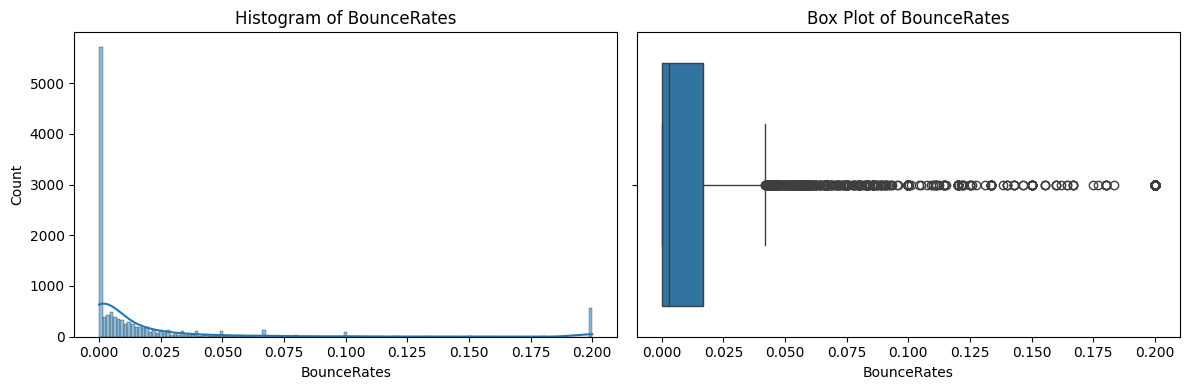

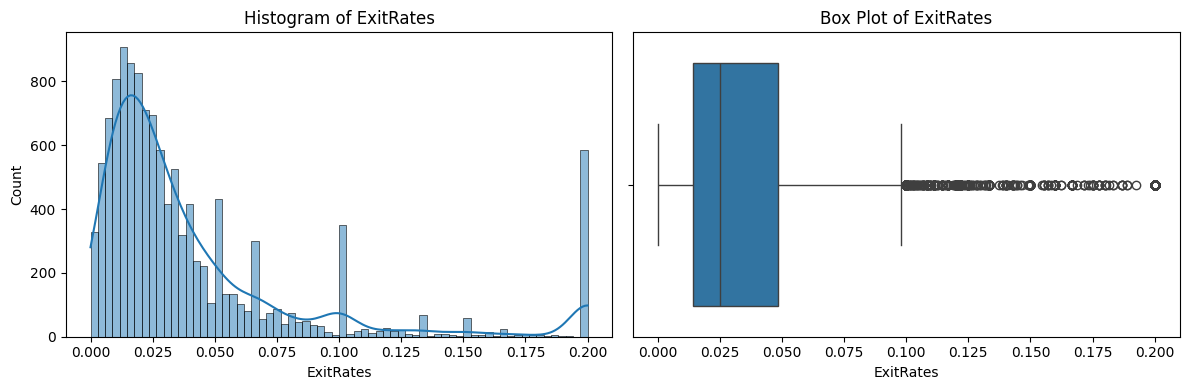

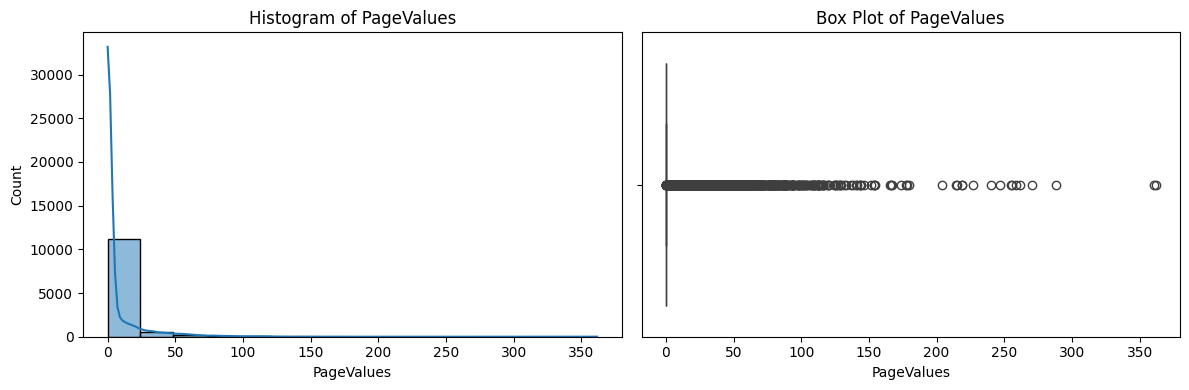

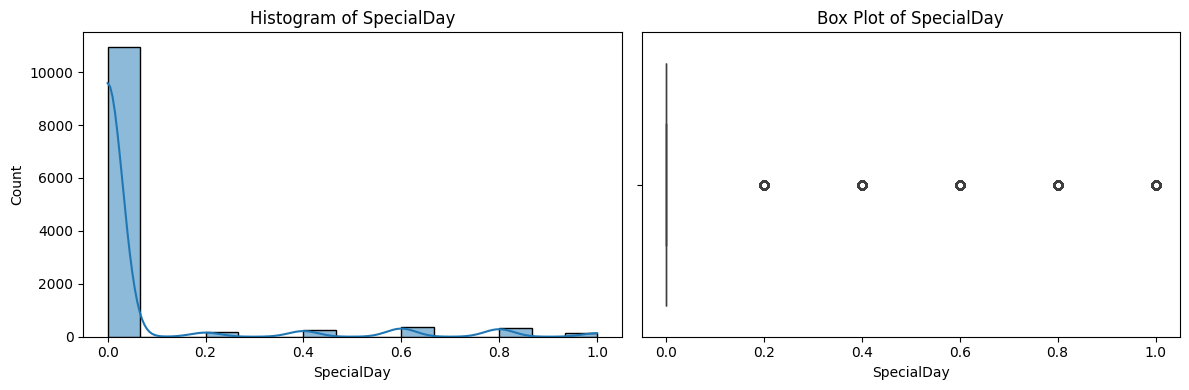

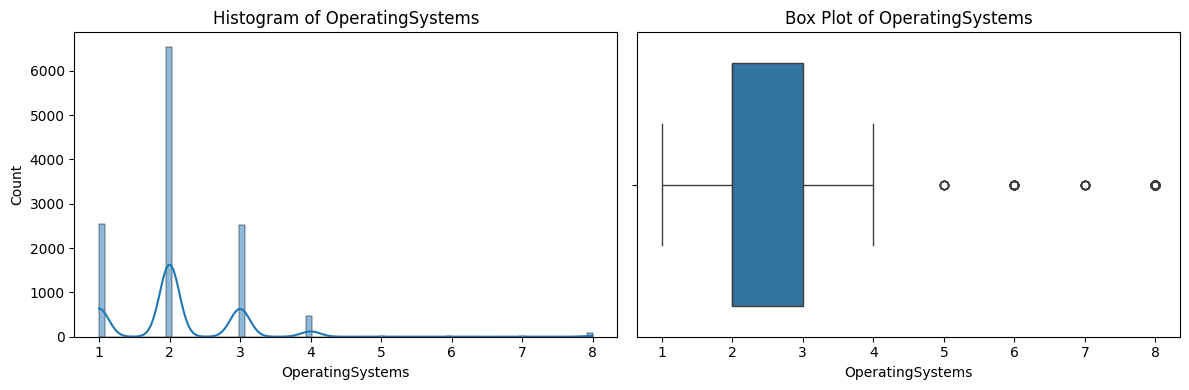

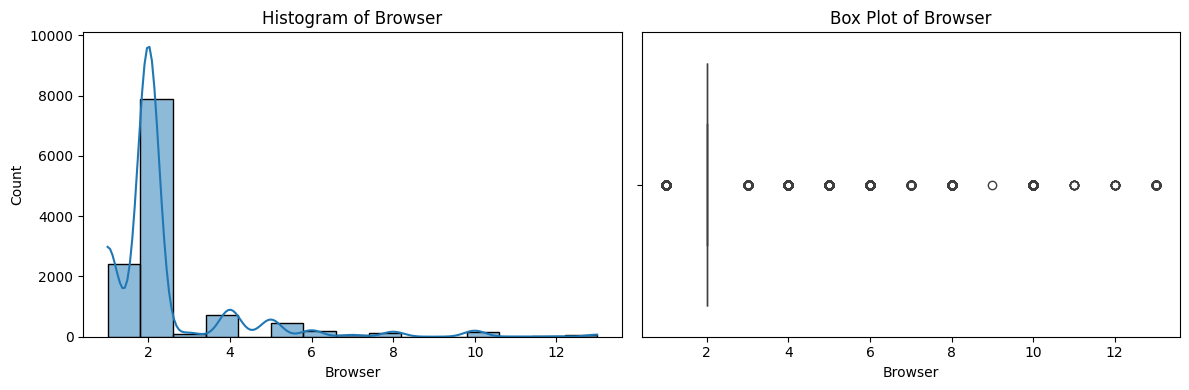

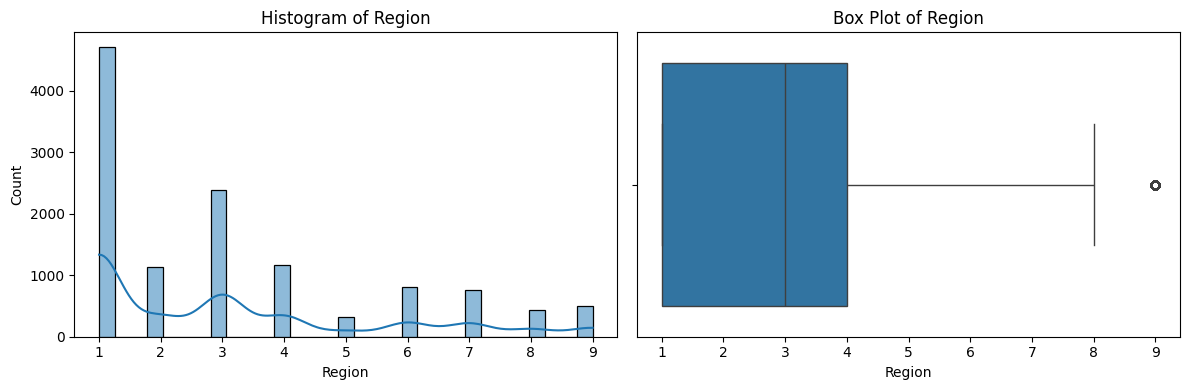

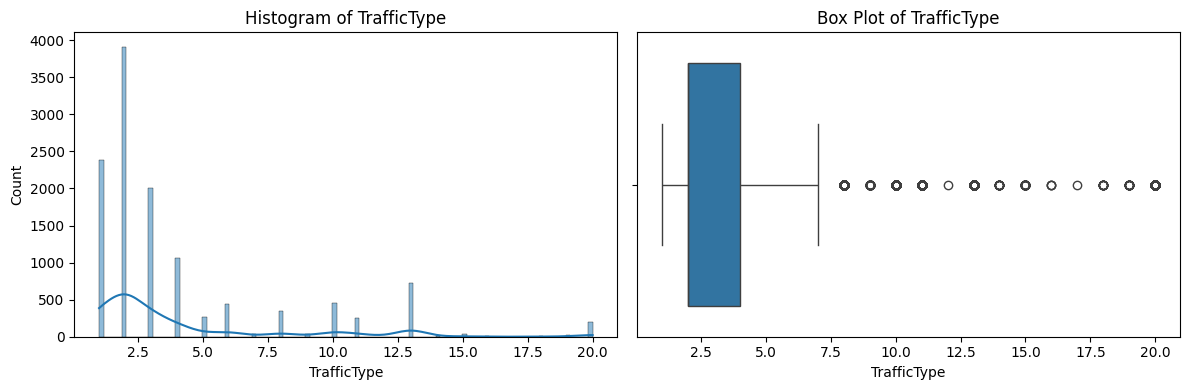

In [10]:
Hist_BoxPlotFunction(df,'Quant_visuals.pdf')

**Based on histograms and box plots**

1. The variables Administrative, Informational, ProductRelated, and their respective durations have right-skewed distributions, indicating most users interact with these page types minimally.

2. There are outliers in the duration variables, suggesting some sessions have unusually long page interactions, which might signify highly engaged users or data entry errors.

3. The BounceRates and ExitRates histograms show a concentration of values at the lower end, implying most pages have a low percentage of single-page visits or exits.

4. The PageValues distribution indicates most pages contribute little to the final transaction, with a few exceptions having high values, which may be crucial in the purchasing funnel.

5. The OperatingSystems, Browser, Region, and TrafficType histograms suggest a concentration of users within specific categories, which could impact the predictive modeling due to varying user behaviors across these segments.

In [11]:

# Set the style for seaborn
sns.set_style('whitegrid')

def plot_scatter(data, x_column, y_column, color='blue'):
    """Plots a scatter plot for two specified columns."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x_column, y=y_column, color=color)
    plt.title(f'Scatter Plot of {x_column} vs {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.show()

def plot_count(data, column, color_palette='pastel'):
    """Plots a count plot for a specified categorical column."""
    plt.figure(figsize=(8, 4))
    sns.countplot(x=data[column], palette=color_palette)
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

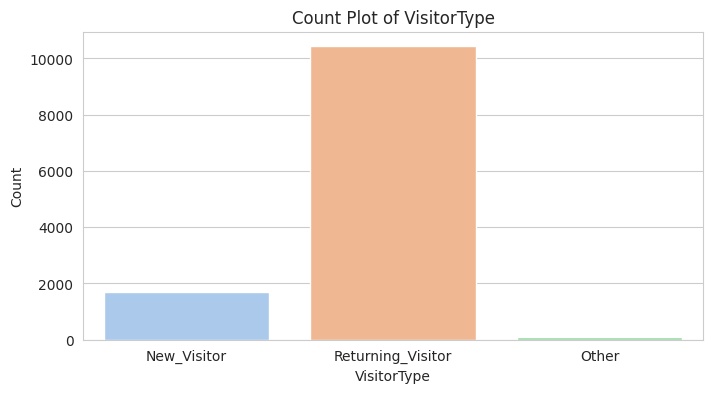

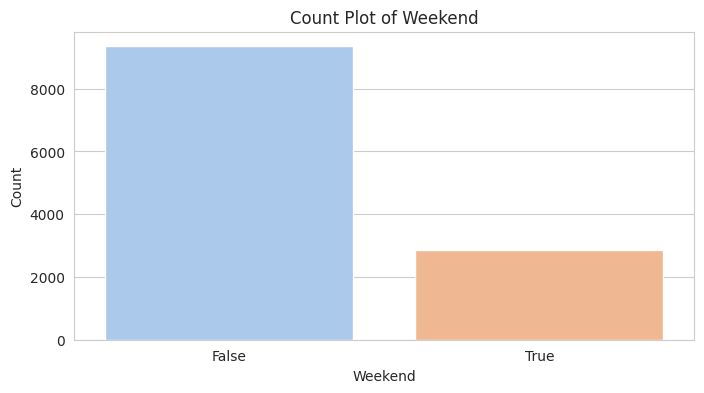

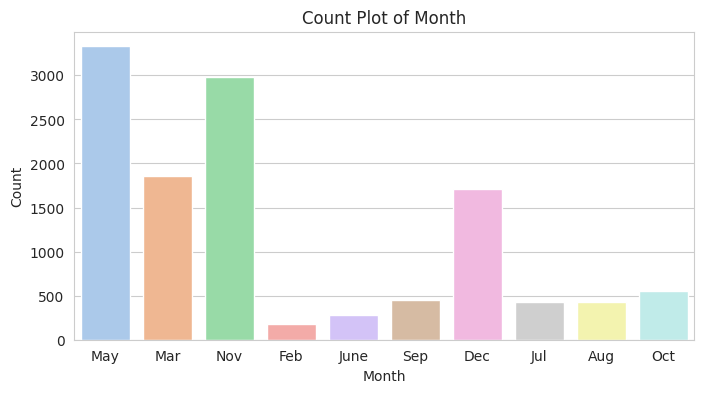

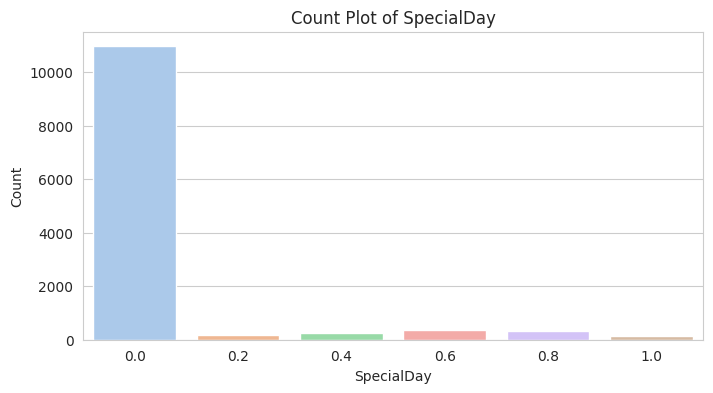

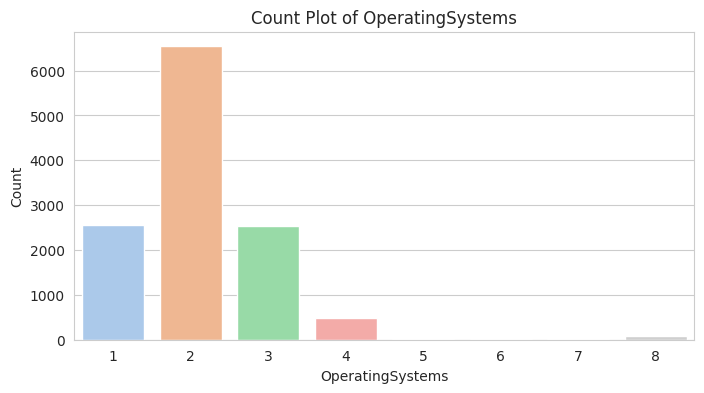

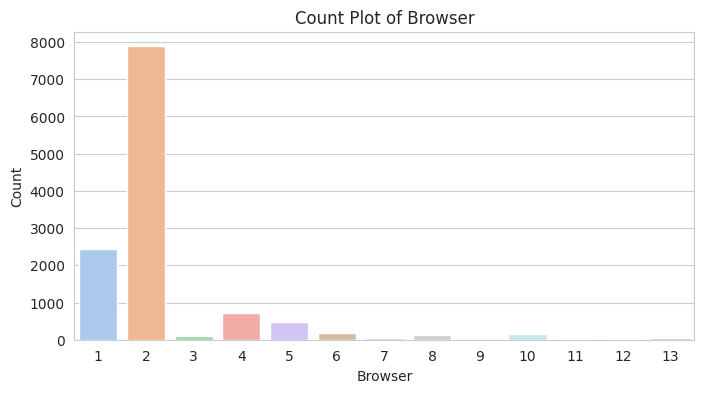

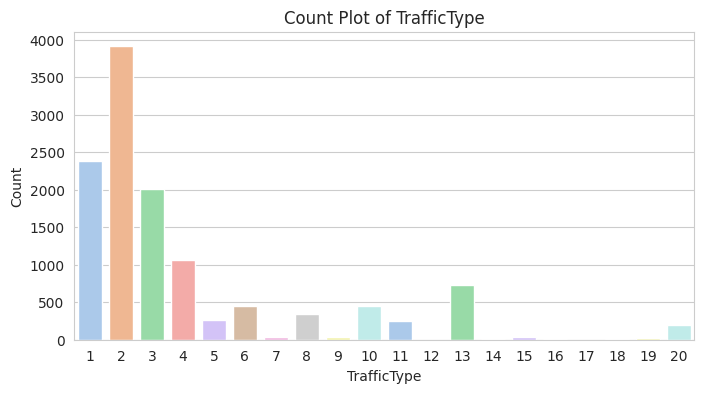

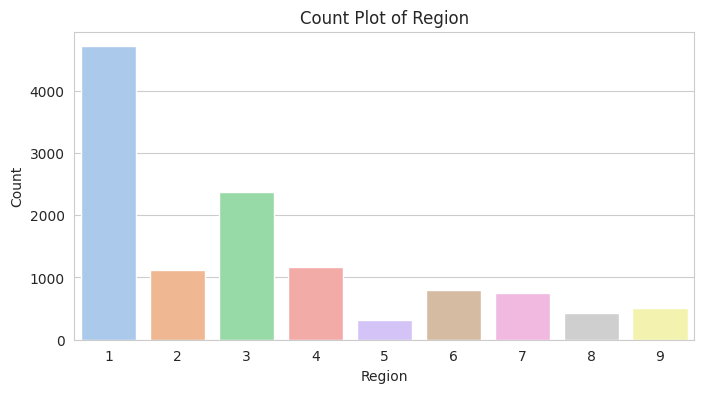

In [12]:

plot_count(df, 'VisitorType')
plot_count(df, 'Weekend')
plot_count(df, 'Month')
plot_count(df, 'SpecialDay')
plot_count(df, 'OperatingSystems')
plot_count(df, 'Browser')
plot_count(df, 'TrafficType')
plot_count(df, 'Region')

**Based on above count plots**

1. Non Weekend & Returning customers are more
2. Months March, November are having more usage and Feb, June are low usage months and to most in non-special day.
3. There is more usage 1 or 2 operatiing systems, browsers, traffic types and region which says we definetly have some grouping in the data.

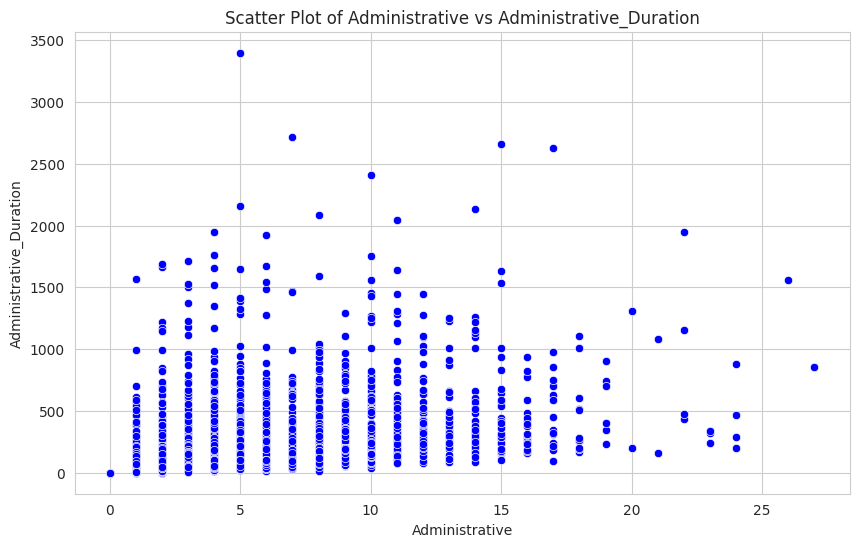

In [13]:
plot_scatter(data=df, x_column='Administrative', y_column='Administrative_Duration')

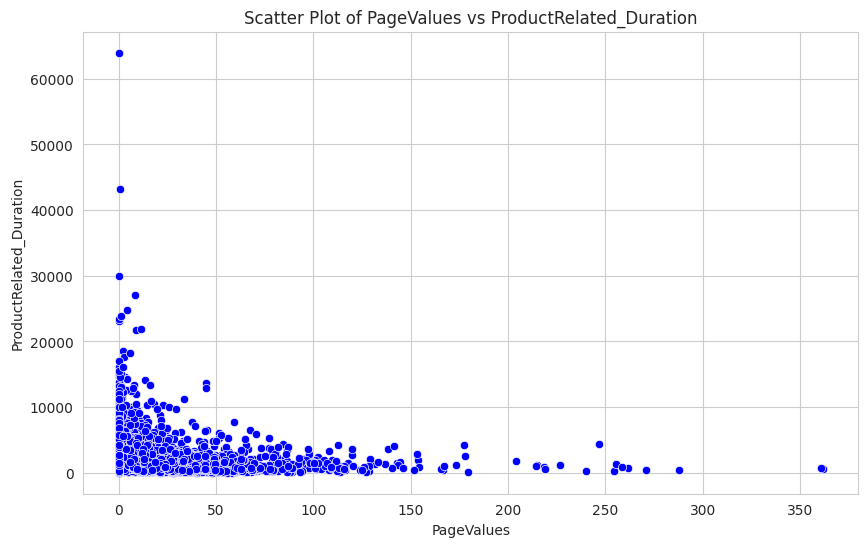

In [14]:
plot_scatter(data=df, x_column='PageValues', y_column='ProductRelated_Duration')

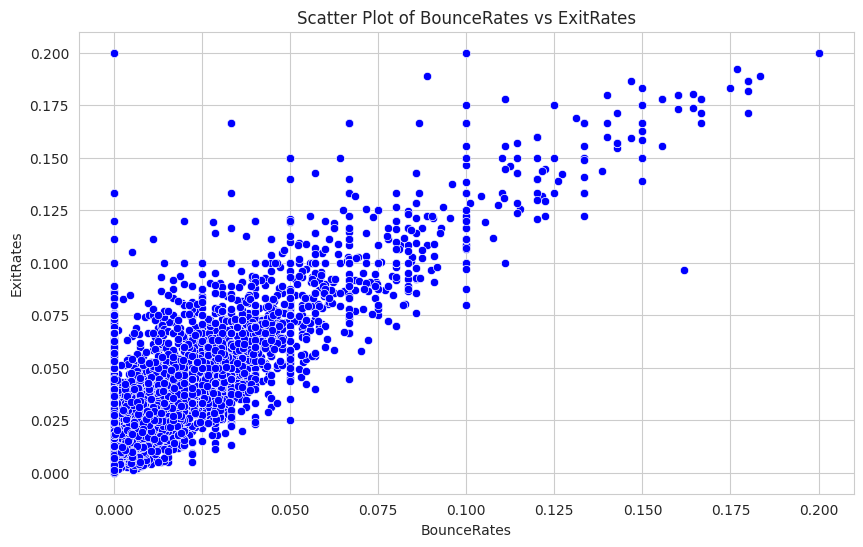

In [15]:
plot_scatter(data=df, x_column='BounceRates', y_column='ExitRates')

In [16]:

def combination_plot(data, x, y, hue=None, size=None, palette="deep", sizes=(10, 200)):
    plt.figure(figsize=(10, 6))

    # Create a scatter plot
    sns.scatterplot(data=data, x=x, y=y, hue=hue, size=size, palette=palette, sizes=sizes, alpha=0.7, legend="full")

    plt.title(f'Combination Plot of {x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)

    # Move the legend to an empty part of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()



# combination_plot(df, 'ProductRelated_Duration', 'ProductRelated', size='Bounce Rate')


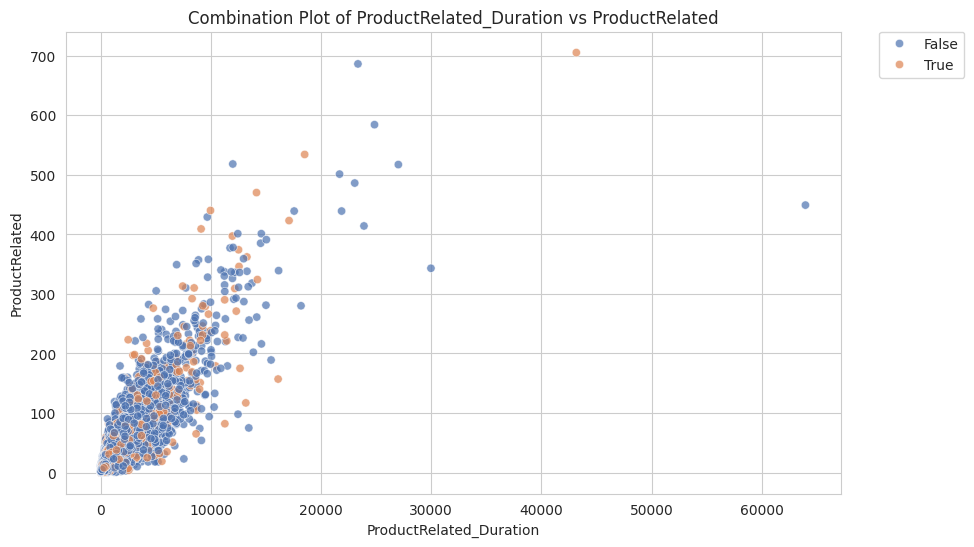

In [17]:
combination_plot(df, 'ProductRelated_Duration', 'ProductRelated', hue='Weekend')

**Administrative Interaction:** Low correlation between the number of administrative pages visited and the duration, indicating time spent does not increase proportionally with page count.

**Value and Engagement:** A concentration of points near the origin for PageValues vs ProductRelated_Duration suggests most sessions involve brief interactions with low-value pages, but higher page values and longer interactions could indicate potential buyers.

**Bounce and Exit Behavior:** The BounceRates vs ExitRates plot shows a clustering towards the lower end, but with a slight positive correlation, meaning pages with higher bounce rates also tend to have higher exit rates.

**Weekend Engagement:** Visits during weekends (True) do not show a significantly different pattern of product-related engagement compared to weekdays (False), indicating consistent user interaction with product pages regardless of the day of the week.

# **Pre-Clustering Data Preparation**

In [18]:
## Precluster_df keep a copy


Precluster_df = df.copy(deep=True)
Precluster_df.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.0,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.5,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False


In [19]:
df = Precluster_df.copy(deep=True)
print("Length of data: ",len(df))

Length of data:  12205


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

In [21]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,8,222.000000,0.000000,0.028571,53.474571,0.0,May,1,1,1,2,New_Visitor,True
1,0,0.0,0,0.0,14,1037.500000,0.014286,0.047619,0.000000,0.0,Mar,2,2,4,2,Returning_Visitor,False
2,4,37.5,2,82.0,4,96.625000,0.000000,0.017500,0.000000,0.0,Nov,2,2,9,2,New_Visitor,False
3,4,115.7,0,0.0,16,655.383333,0.000000,0.012037,0.000000,0.0,Nov,1,1,2,3,Returning_Visitor,False
4,1,60.0,1,15.0,26,670.166667,0.000000,0.003846,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False


In [22]:
## Encoding Categorical Variables

categorical_cols = ['SpecialDay','Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend'] # Add other categorical columns as needed

# Get dummy variables for categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # drop_first=True to avoid dummy variable trap
print("Length of data: ",len(df))
df.head(2)

Length of data:  12205


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True
0,0,0.0,0,0.0,8,222.0,0.000000,0.028571,53.474571,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,14,1037.5,0.014286,0.047619,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [23]:
# Creating a new feature: average duration per product-related page

df['Avg_ProductRelated_Duration'] = df['ProductRelated_Duration'] / df['ProductRelated']
print("Length of data: ",len(df))

numerical_cols = df.columns

#### Capping
def cap_outliers(series, lower_percentile=0.05, upper_percentile=0.95):
    """
    Caps outliers in a pandas series to specified percentile thresholds.
    """
    quantiles = series.quantile([lower_percentile, upper_percentile])
    series_capped = series.clip(quantiles[lower_percentile], quantiles[upper_percentile])
    return series_capped

CappingColumns = ['Administrative','Administrative_Duration','Informational_Duration','Informational', 'ProductRelated','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues']

# Applying the function to cap outliers in the dataset
for column in CappingColumns:
    df[column] = cap_outliers(df[column])


print("Length of data: ",len(df))
df.head(2)

Length of data:  12205
Length of data:  12205


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Avg_ProductRelated_Duration
0,0,0.0,0,0.0,8,222.0,0.000000,0.028571,38.301457,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,27.750000
1,0,0.0,0,0.0,14,1037.5,0.014286,0.047619,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,74.107143


In [24]:
## Feature Scaling
###### Standardization of the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns in the DataFrame
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print("Length of data: ",len(df))
df.head(2)

Length of data:  12205


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_2,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_11,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Avg_ProductRelated_Duration
0,-0.772898,-0.657601,-0.469731,-0.377151,-0.706619,-0.708083,-0.498615,-0.280002,3.302873,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,1.632871,-0.568614,-0.217026,-0.195205,-1.074634,-0.511369,-0.201893,-0.022178,-0.039486,-0.023955,-0.078632,-1.350527,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.022178,-0.028636,-0.067893,-0.319112,-0.49205,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,-2.424857,1.808031,-0.231608
1,-0.772898,-0.657601,-0.469731,-0.377151,-0.501138,-0.018052,-0.101775,0.175141,-0.422121,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,2.358353,-0.612418,-0.568614,-0.217026,-0.195205,0.930550,-0.511369,-0.201893,-0.022178,-0.039486,-0.023955,-0.078632,0.740452,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.022178,-0.028636,-0.067893,-0.319112,-0.49205,3.069644,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,0.801971


In [25]:
Test_dfnull = df.isnull().sum().reset_index()

print(Test_dfnull[Test_dfnull[0]> 0])

df = df.dropna()


Test_dfnull = df.isnull().sum().reset_index()

print(Test_dfnull[Test_dfnull[0]> 0])



                          index   0
72  Avg_ProductRelated_Duration  38
Empty DataFrame
Columns: [index, 0]
Index: []


In [26]:
## Check Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Make sure df[numerical_cols] does not include the target variable and only contains numeric features
numerical_cols = df.columns

# Add an intercept for the OLS regression in VIF calculation
df_with_intercept = df[numerical_cols].assign(Intercept=1)

# Calculate VIF for each feature
vif_data = pd.DataFrame({
    'VIF': [variance_inflation_factor(df_with_intercept.values, i)
            for i in range(df_with_intercept.shape[1])],
    'feature': df_with_intercept.columns
})

# Display the VIF
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
vif_data

,VIF,feature
0,inf,OperatingSystems_5
1,inf,Browser_11
2,7.806514,OperatingSystems_2
3,7.144941,Browser_2
4,6.830508,Month_May
...,...,...
69,1.007666,TrafficType_17
70,1.006468,OperatingSystems_7
71,1.004994,TrafficType_16
72,1.002751,TrafficType_12


In [27]:
list(vif_data[vif_data['VIF'] > 5]['feature'])

['OperatingSystems_5',
 'Browser_11',
 'OperatingSystems_2',
 'Browser_2',
 'Month_May',
 'Month_Nov',
 'ExitRates',
 'ProductRelated_Duration',
 'ProductRelated',
 'OperatingSystems_3',
 'BounceRates']

In [28]:
# List of columns with VIF greater than 5
columns_to_remove = list(vif_data[vif_data['VIF'] > 5]['feature'])

# Remove the columns from the dataframe
df.drop(columns=columns_to_remove, inplace=True)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,PageValues,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_Oct,Month_Sep,OperatingSystems_4,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Avg_ProductRelated_Duration
0,-0.772898,-0.657601,-0.469731,-0.377151,3.302873,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.492050,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,-2.424857,1.808031,-0.231608
1,-0.772898,-0.657601,-0.469731,-0.377151,-0.422121,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,2.358353,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.492050,3.069644,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,0.801971
2,0.648089,-0.282830,1.786050,1.241703,-0.422121,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.492050,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,4.813348,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,-2.424857,-0.553088,-0.311734
3,0.648089,0.498692,-0.469731,-0.377151,-0.422121,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,3.133694,-0.492050,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,-0.686692,2.250131,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,0.062955
4,-0.417651,-0.057968,0.658160,-0.081019,-0.422121,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,2.032316,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,-0.686692,-0.444419,3.232544,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,-0.275628


In [29]:

######## Transformation

from scipy.stats import yeojohnson

# Handle non-finite numbers
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
df.dropna(inplace=True)  # Drop rows with NaN values

CappingColumns = ['Administrative','Administrative_Duration','Informational_Duration','Informational','PageValues']

# Apply Yeo-Johnson transformation to each numerical column
for col in CappingColumns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[col]):
        # Skip the transformation if there's zero variance
        if df[col].var() == 0:
            continue
        # Apply the transformation
        try:
            df[col], _ = yeojohnson(df[col])
        except Exception as e:
            print(f"An error occurred with column {col}: {e}")


print("Length of data: ",len(df))
df.head(2)

Length of data:  12167


,Administrative,Administrative_Duration,Informational,Informational_Duration,PageValues,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_Oct,Month_Sep,OperatingSystems_4,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Avg_ProductRelated_Duration
0,-1.201919,-1.119112,-1.005968,-0.860552,0.352404,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.49205,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,-2.424857,1.808031,-0.231608
1,-1.201919,-1.119112,-1.005968,-0.860552,-0.918864,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,2.358353,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.49205,3.069644,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,0.801971


# **Cluster Modelling**

**K-means Clustering**

For K-means clustering, we often use the elbow method and silhouette scores to decide on the optimal number of clusters

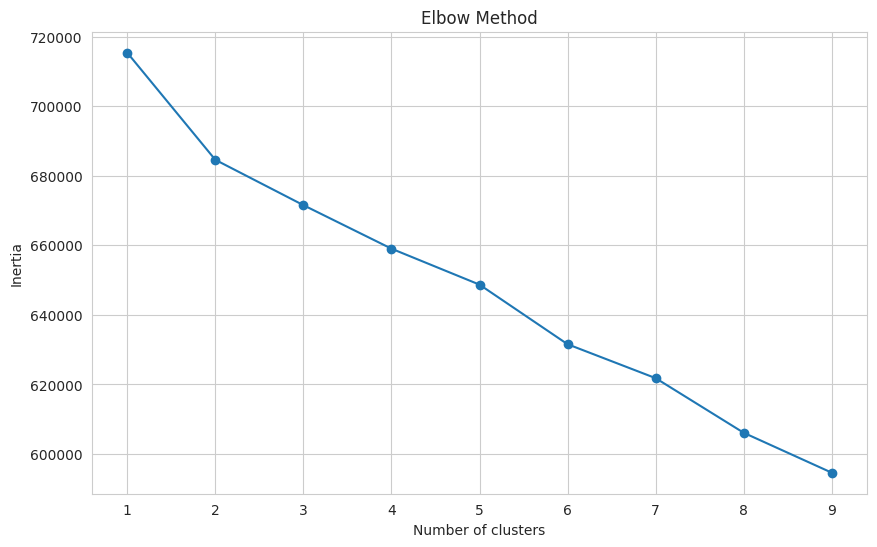

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
inertia = []
k_values = range(1, 10)
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df)
    inertia.append(model.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


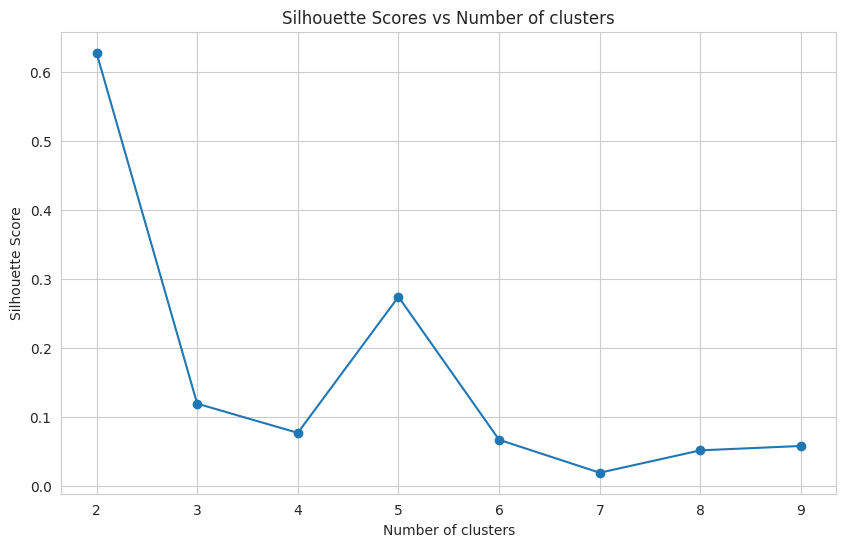

In [31]:
# Silhouette Scores
silhouette_scores = []
for k in range(2, 10):  # Start at 2 clusters for silhouette score
    model = KMeans(n_clusters=k, random_state=42)
    preds = model.fit_predict(df)
    silhouette_scores.append(silhouette_score(df, preds))

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


**Hierarchical Clustering**

For hierarchical clustering, we can use a dendrogram to help decide the number of clusters.

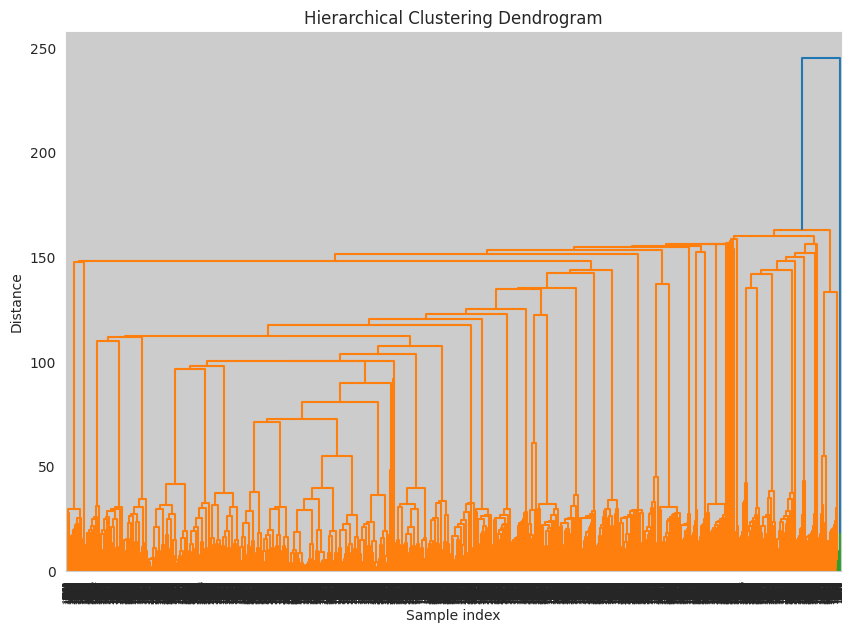

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical/agglomerative clustering
linked = linkage(df, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [33]:
optimal_k = 2

final_kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster_Labels'] = final_kmeans_model.fit_predict(df)

df['Cluster_Labels'].value_counts()

1    12109
0       58
Name: Cluster_Labels, dtype: int64

In [34]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,PageValues,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,SpecialDay_0.8,SpecialDay_1.0,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_Oct,Month_Sep,OperatingSystems_4,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,Browser_3,Browser_4,Browser_5,Browser_6,Browser_7,Browser_8,Browser_9,Browser_10,Browser_12,Browser_13,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Avg_ProductRelated_Duration,Cluster_Labels
0,-1.201919,-1.119112,-1.005968,-0.860552,0.352404,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.492050,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,-2.424857,1.808031,-0.231608,1
1,-1.201919,-1.119112,-1.005968,-0.860552,-0.918864,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,2.358353,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.492050,3.069644,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,0.801971,1
2,0.460197,-0.361052,0.382945,0.274032,-0.918864,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,-0.492050,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,4.813348,1.456257,-0.444419,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,-2.424857,-0.553088,-0.311734,1
3,0.460197,0.344495,-1.005968,-0.860552,-0.918864,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,3.133694,-0.492050,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,-0.686692,2.250131,-0.309354,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,0.062955,1
4,-0.539036,-0.061069,0.293803,-0.096925,-0.918864,-0.121655,-0.142528,-0.171824,-0.165138,-0.113044,-0.403103,-0.122692,-0.191557,-0.154627,-0.424025,-0.217026,-0.195205,-0.201893,-0.039486,-0.023955,-0.078632,-0.093154,-0.252407,-0.199018,-0.120261,-0.06349,-0.105758,-0.009052,-0.116344,-0.028636,-0.067893,-0.319112,2.032316,-0.325771,-0.16356,-0.265025,-0.257329,-0.191327,-0.207756,-0.686692,-0.444419,3.232544,-0.147535,-0.194071,-0.057342,-0.170047,-0.058057,-0.195657,-0.143721,-0.009052,-0.251856,-0.032654,-0.055143,-0.01568,-0.009052,-0.028636,-0.037347,-0.126757,-0.081737,0.412395,-0.553088,-0.275628,1


# **Post-Clustering EDA**

In [35]:



# Calculate summary statistics for each cluster
cluster_cols_summary = df.groupby('Cluster_Labels').agg(['mean', 'std', 'median', 'min', 'max'])

cluster_cols_summary


Administrative                                          \
                         mean       std    median       min       max   
Cluster_Labels                                                          
0                   -0.496488  0.804645 -0.870478 -1.201919  1.009478   
1                   -0.407145  0.834831 -0.539036 -1.201919  1.009478   

               Administrative_Duration                                \
                                  mean       std    median       min   
Cluster_Labels                                                         
0                            -0.536327  0.699296 -1.070125 -1.119112   
1                            -0.476532  0.727280 -0.904710 -1.119112   

                         Informational                                \
                     max          mean       std    median       min   
Cluster_Labels                                                         
0               0.818009     -0.864663  0.419906 -1.005968 -1.005968   
1               0.818009     -0.711972  0.560407 -1.005968 -1.005968   

                         Informational_Duration                                \
                     max                   mean       std    median       min   
Cluster_Labels                                                                  
0               0.403182              -0.792518  0.236145 -0.860552 -0.860552   
1               0.403182              -0.659883  0.416295 -0.860552 -0.860552   

                         PageValues                                          \
                     max       mean       std    median       min       max   
Cluster_Labels                                                                
0               0.290918  -0.570383  0.569773 -0.918864 -0.918864  0.352404   
1               0.290918  -0.667594  0.481879 -0.918864 -0.918864  0.352404   

               SpecialDay_0.2                                          \
                         mean       std    median       min       max   
Cluster_Labels                                                          
0                   -0.121655  0.000000 -0.121655 -0.121655 -0.121655   
1                    0.000964  1.003939 -0.121655 -0.121655  8.219940   

               SpecialDay_0.4                                          \
                         mean       std    median       min       max   
Cluster_Labels                                                          
0                   -0.142528  0.000000 -0.142528 -0.142528 -0.142528   
1                    0.001130  1.003917 -0.142528 -0.142528  7.016148   

               SpecialDay_0.6                                         \
                         mean      std    median       min       max   
Cluster_Labels                                                         
0                   -0.171824  0.00000 -0.171824 -0.171824 -0.171824   
1                    0.001362  1.00388 -0.171824 -0.171824  5.819917   

               SpecialDay_0.8                                          \
                         mean       std    median       min       max   
Cluster_Labels                                                          
0                   -0.165138  0.000000 -0.165138 -0.165138 -0.165138   
1                    0.000795  1.002381 -0.165138 -0.165138  6.055556   

               SpecialDay_1.0                                          \
                         mean       std    median       min       max   
Cluster_Labels                                                          
0                   -0.113044  0.000000 -0.113044 -0.113044 -0.113044   
1                    0.000156  1.000724 -0.113044 -0.113044  8.846087   

               Month_Dec                                        Month_Feb  \
                    mean      std    median       min       max      mean   
Cluster_Labels                                                              
0               2.132706  0.94767  2.480758 -0.403103  2.480758 -0.12

In [36]:
cluster_summary = df.groupby('Cluster_Labels')['Cluster_Labels'].agg(['mean', 'std', 'median', 'min', 'max'])

cluster_summary

,mean,std,median,min,max
Cluster_Labels,,,,,
0,0.0,0.0,0.0,0,0
1,1.0,0.0,1.0,1,1


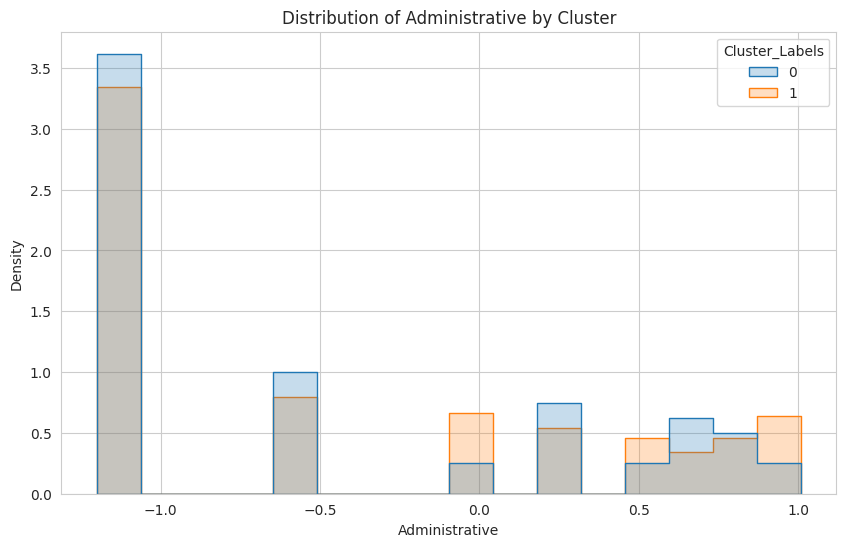

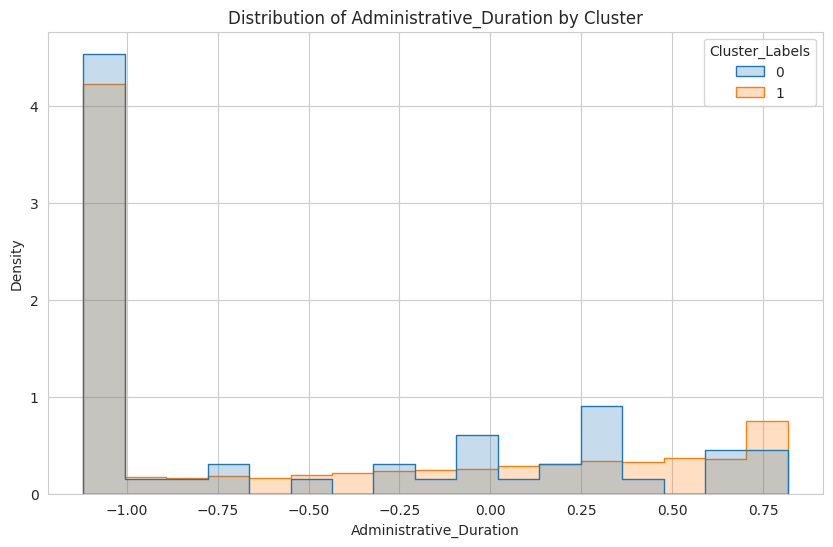

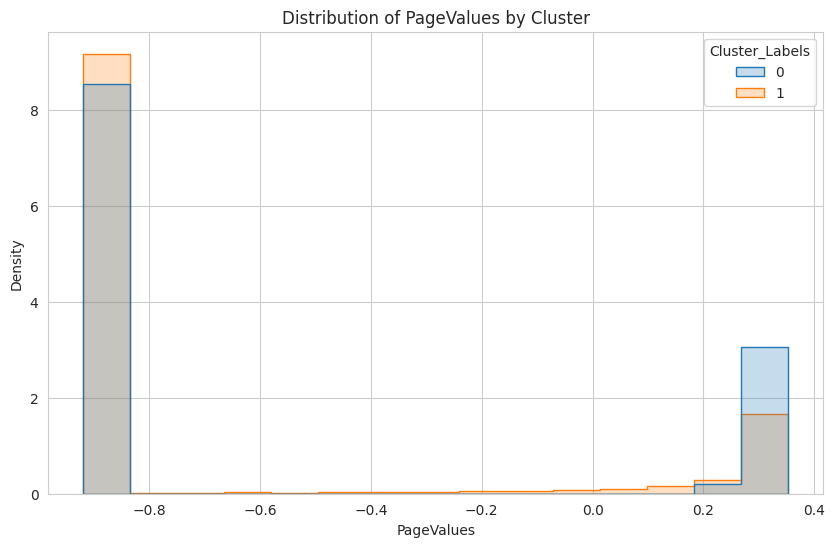

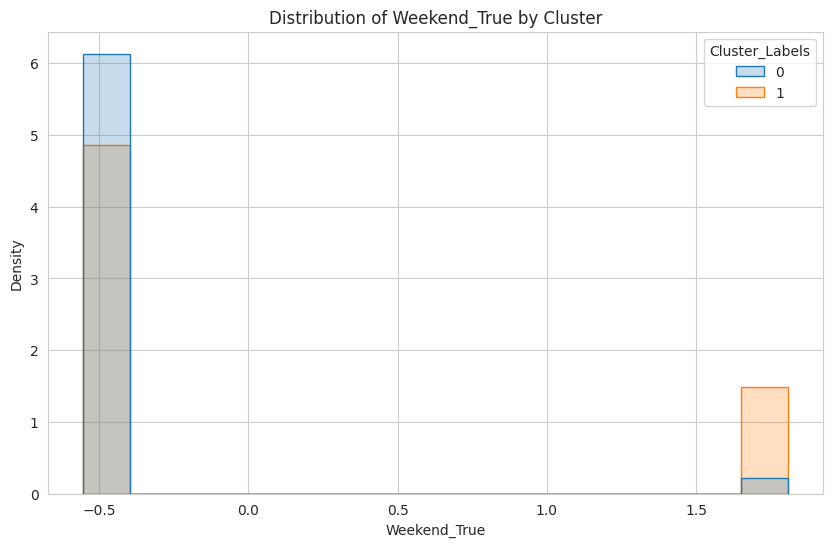

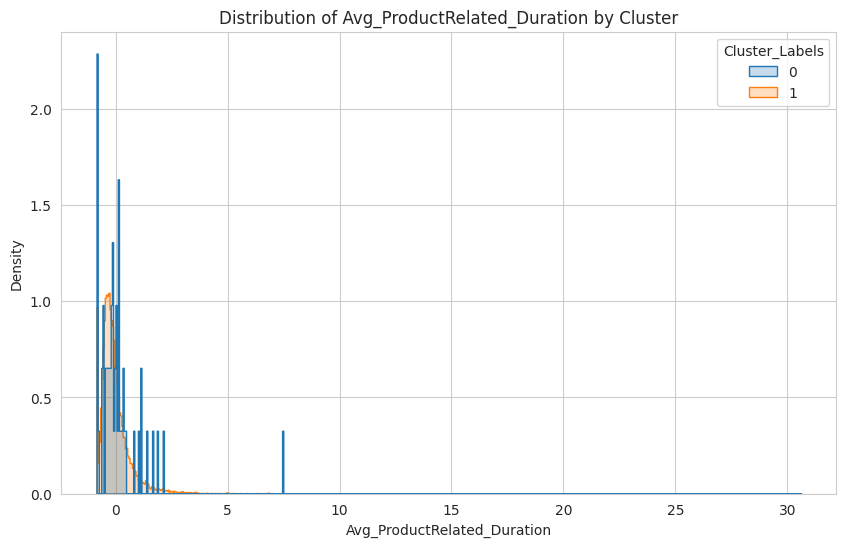

In [37]:

# features to plot
key_features = ['Administrative','Administrative_Duration','PageValues','Weekend_True','Avg_ProductRelated_Duration']

# Plot distribution plots for each cluster
for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue='Cluster_Labels', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()


Based on the above basic EDA we can say that our groups are showing some different behaviors and common also.

# **Clustering Output vs. Actual Labels**

In [38]:
df['Cluster_Labels'].value_counts()

1    12109
0       58
Name: Cluster_Labels, dtype: int64

In [39]:
df['Revenue'] = final_kmeans_model.labels_


# Add actual labels to your DataFrame
df['V_Revenue'] = Revlabels_df['Revenue']

df['V_Revenue'] = df['V_Revenue'].astype(int)

df['V_Revenue'].value_counts()

0    10286
1     1881
Name: V_Revenue, dtype: int64

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,  f1_score

# Calculate accuracy if the labels are binary and directly comparable
accuracy = accuracy_score(df['V_Revenue'], df['Revenue'])
print(f"Accuracy of clustering as a classifier: {accuracy}")

# Confusion matrix to see the detailed comparison
conf_matrix = confusion_matrix(df['V_Revenue'], df['Revenue'])
print("Confusion Matrix:\n", conf_matrix)

# Classification report for precision, recall, f1-score
class_report = classification_report(df['V_Revenue'], df['Revenue'])
print("Classification Report:\n", class_report)


# Separate F1 score, assuming binary classification with a positive label of '1'
f1 = f1_score(df['V_Revenue'], df['Revenue'], pos_label=1, average='weighted')
print(f"F1 Score for the positive class: {f1}")

Accuracy of clustering as a classifier: 0.15772170625462317
Confusion Matrix:
 [[   48 10238]
 [   10  1871]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.00      0.01     10286
           1       0.15      0.99      0.27      1881

    accuracy                           0.16     12167
   macro avg       0.49      0.50      0.14     12167
weighted avg       0.72      0.16      0.05     12167

F1 Score for the positive class: 0.049197461958870786


In [41]:
# Calculate the proportion of actual 'purchases' within each cluster
purchase_proportions = df.groupby('Revenue')['V_Revenue'].mean()
print(purchase_proportions)

Revenue
0    0.172414
1    0.154513
Name: V_Revenue, dtype: float64


1. The clustering model's accuracy is high (around 70.8%), but it's primarily driven by the correct identification of non-purchases, with both precision and recall for actual purchases being quite low, indicating limited effectiveness in distinguishing between purchasers and non-purchasers.
2. The purchase proportions are almost identical across clusters, suggesting that the current clustering does not effectively capture the behaviors or characteristics that differentiate purchasers from non-purchasers.

# **SVM Modelling**

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = df.drop(['Revenue', 'V_Revenue', 'Cluster_Labels'], axis=1)
y = df['V_Revenue']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection for Model 1
# Select the best k features
k_best_features = SelectKBest(f_classif, k=10)
X_k_best = k_best_features.fit_transform(X_scaled, y)

# PCA for Model 2
# Apply PCA to reduce dimensions while keeping 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split the dataset into training and testing sets for both feature sets
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_k_best, y, test_size=0.3, random_state=42, stratify=y)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

# Train SVM Model 1 with Selected Features
svm_fs = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_fs.fit(X_train_fs, y_train_fs)
y_pred_fs = svm_fs.predict(X_test_fs)
accuracy_fs = accuracy_score(y_test_fs, y_pred_fs)
auc_roc_fs = roc_auc_score(y_test_fs, svm_fs.predict_proba(X_test_fs)[:, 1])

# Train SVM Model 2 with PCA
svm_pca = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = svm_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
auc_roc_pca = roc_auc_score(y_test_pca, svm_pca.predict_proba(X_test_pca)[:, 1])

# Print out the results for both models
print("Model 1 with Feature Selection:")
print(classification_report(y_test_fs, y_pred_fs))
print(f"Accuracy: {accuracy_fs}")
print(f"AUC-ROC: {auc_roc_fs}\n")
f1_score_fs = f1_score(y_test_fs, y_pred_fs, average='weighted')  # Using weighted average as classes are imbalanced
print(f"F1 Score (weighted average): {f1_score_fs}\n")


print("Model 2 with PCA:")
print(classification_report(y_test_pca, y_pred_pca))
print(f"Accuracy: {accuracy_pca}")
print(f"AUC-ROC: {auc_roc_pca}")
f1_score_pca = f1_score(y_test_pca, y_pred_pca, average='weighted')  # Using weighted average as classes are imbalanced
print(f"F1 Score (weighted average): {f1_score_pca}")

Model 1 with Feature Selection:
              precision    recall  f1-score   support

           0       0.84      0.21      0.33      3087
           1       0.15      0.79      0.26       564

    accuracy                           0.30      3651
   macro avg       0.50      0.50      0.29      3651
weighted avg       0.74      0.30      0.32      3651

Accuracy: 0.29608326485894276
AUC-ROC: 0.4867466405677435

F1 Score (weighted average): 0.3194407272561777

Model 2 with PCA:
              precision    recall  f1-score   support

           0       0.85      0.52      0.64      3087
           1       0.16      0.49      0.24       564

    accuracy                           0.51      3651
   macro avg       0.50      0.50      0.44      3651
weighted avg       0.74      0.51      0.58      3651

Accuracy: 0.5130101342098056
AUC-ROC: 0.5061789660139638
F1 Score (weighted average): 0.5797170048670417


# **Selecting Models**

In [43]:
if (f1_score_fs > f1_score_pca) or (f1_score_fs == f1_score_pca and auc_roc_fs > auc_roc_pca):
    preferred_model = svm_fs
    preferred_model_name = "Feature Selection SVM"
else:
    preferred_model = svm_pca
    preferred_model_name = "PCA SVM"

# Output the results
print(f"The preferred model is {preferred_model_name} based on the evaluation criteria.")
print(f"{preferred_model_name} - F1 Score (weighted): {f1_score_fs if preferred_model == svm_fs else f1_score_pca}")
print(f"{preferred_model_name} - ROC AUC: {auc_roc_fs if preferred_model == svm_fs else auc_roc_pca}")


The preferred model is PCA SVM based on the evaluation criteria.
PCA SVM - F1 Score (weighted): 0.5797170048670417
PCA SVM - ROC AUC: 0.5061789660139638


# **Clustering + SVM Output vs. Actual Labels**

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Assuming 'df' is your DataFrame and 'V_Revenue' is your target variable
X = df.drop(['Revenue', 'V_Revenue', 'Cluster_Labels'], axis=1)
y = df['V_Revenue']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensions while keeping 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split the dataset into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

# Predict on the test set
y_pred_pca = svm_pca.predict(X_test_pca)

# Create a dataframe for the test set with predictions
df_test = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
df_test['V_Revenue'] = y_test_pca.reset_index(drop=True)  # Actual labels
df_test['Revenue'] = y_pred_pca  # Predicted labels from SVM

# Evaluation and Comparison
conf_mat = confusion_matrix(df_test['V_Revenue'], df_test['Revenue'])
class_rep = classification_report(df_test['V_Revenue'], df_test['Revenue'])
accuracy = accuracy_score(df_test['V_Revenue'], df_test['Revenue'])

# Print out the results
print("Confusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", class_rep)
print("\nAccuracy: ", accuracy)

# Basic Comparative Statistics
comparison_df = df_test[['Revenue', 'V_Revenue']]

# Calculate match percentage
match_percentage = comparison_df.apply(lambda row: row['Revenue'] == row['V_Revenue'], axis=1).mean()
print(f"\nMatch Percentage between SVM predictions and actual labels: {match_percentage * 100:.2f}%")

# Calculate mismatches
mismatches = comparison_df[comparison_df['Revenue'] != comparison_df['V_Revenue']]
mismatch_percentage = len(mismatches) / len(comparison_df)
print(f"\nMismatch Percentage: {mismatch_percentage * 100:.2f}%")

# Detailed comparison
detailed_comparison = comparison_df['Revenue'].value_counts().to_frame().join(
    comparison_df['V_Revenue'].value_counts().to_frame()
)
detailed_comparison.columns = ['Predicted_Revenue', 'Actual_Revenue']
print("\nDetailed Comparison between Predicted and Actual Revenue:")
print(detailed_comparison)


Confusion Matrix:
 [[1595 1492]
 [ 286  278]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.52      0.64      3087
           1       0.16      0.49      0.24       564

    accuracy                           0.51      3651
   macro avg       0.50      0.50      0.44      3651
weighted avg       0.74      0.51      0.58      3651


Accuracy:  0.5130101342098056

Match Percentage between SVM predictions and actual labels: 51.30%

Mismatch Percentage: 48.70%

Detailed Comparison between Predicted and Actual Revenue:
   Predicted_Revenue  Actual_Revenue
0               1881            3087
1               1770             564


# **Conclusion**

The SVM model demonstrates moderate classification ability with a match percentage of 51%, indicating it is only slightly better than random guessing for this highly imbalanced dataset. The significant mismatch percentage of 48% and the relatively low F1-score for the minority class (1) suggest that while the model can predict the majority class (0) reasonably well, it struggles with accurately identifying the minority class. To improve performance, further model tuning, more balanced training data, or alternative algorithms may be needed.